# Predictor de responsabilidad de siniestros viales

Nombre: Alvaro Concha

---
### Objetivos
1. Realizar el análisis exploratorio de los datos para determinar qué campos además de la
descripción tienen importancia para determinar la responsabilidad del hecho.

2. Realizar un modelo que dada las características seleccionadas determine la
responsabilidad del hecho.

3. Realizar un workflow del proceso realizado en los puntos anteriores donde también se
reporten los próximos pasos a seguir al momento de disponibilizar dicho modelo al
cliente.

4. Disponibilizar en un repositorio todo el desarrollo con un esquema de la estructura
deseada del proyecto y la explicación de su abordaje en el “README.md” o en un
Notebook junto con el resto de los puntos.


---
### Atributos originales

Id_evento: es un código identificador

Id_reclamo_evento: es un código identificador

Id_reclamo: es un código identificador

TIPO_RECLAMO: es un código identificador

FECHA_SINI: fecha en la que ocurrió el siniestro

LUGAR_OCURRENCIA: dirección de ocurrencia del siniestro

COD_POST_OCURRENCIA: código postal del lugar donde ocurre el siniestro

ESTADO_CIVIL: estado civil del asegurado

FECHA_NAC_ASEG: fecha de nacimiento del asegurado

SEXO: sexo del asegurado

OCUPACION_ASEG: ocupación codificada del asegurado

MODELO_VEHICULO: año de emisión del vehículo del asegurado

FECHA_PROCESO: fecha en la que se proceso la designación del asegurado

TIPO_ADMINISTRACION: determina la responsabilidad inicial del asegurado

DESCRIP_HECHO: descripción del siniestro en cuestión

HORA_SINI: hora en la que ocurre el siniestro

LATITUD

LONGITUD

TIPO_ADMINISTRACION_FIN: determina la responsabilidad final del asegurado



---
### Setup

Importar librerías y leer datos.

In [1]:
# Instalar librerías y paquetes
# %pip install -r requirements.txt

In [2]:
# !pip freeze > requirements.txt

In [3]:
# Importar librerías y paquetes
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from stanza import Pipeline as StanzaPipeline
from nltk.tokenize import RegexpTokenizer
from spellchecker import SpellChecker
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
from nltk import everygrams
from nltk.classify import NaiveBayesClassifier
from sklearn.compose import ColumnTransformer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, RobustScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.metrics import roc_curve, roc_auc_score, classification_report, confusion_matrix

np.random.seed(42)

/home/alvaro/.local/lib/python3.8/site-packages/xarray/core/merge.py:10: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  PANDAS_TYPES = (pd.Series, pd.DataFrame, pd.Panel)
/usr/lib/python3/dist-packages/requests/__init__.py:89: RequestsDependencyWarning: urllib3 (1.26.12) or chardet (3.0.4) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({}) doesn't match a supported "
2022-08-28 21:15:31.111037: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-08-28 21:15:31.111065: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [4]:
# Un vistazo de las primeras líneas de "siniestros.csv"
with open("siniestros.csv", "r") as file:
    for _ in range(5):
        line = file.readline()
        print(line)

,id_evento,id_reclamo_evento,id_reclamo,TIPO_RECLAMO,FECHA_SINI,LUGAR_OCURRENCIA,COD_POST_OCURRENCIA,ESTADO_CIVIL,FECHA_NAC_ASEG,SEXO,OCUPACION_ASEG,MODELO_VEHICULO,FECHA_PROCESO,TIPO_ADMINISTRACION,DESCRIP_HECHO,HORA_SINI,LATITUD,LONGITUD,TIPO_ADMINISTRACION_FIN

0,1,1,1,NO TRANSPORTADO,1/1/2019,CEBALLOS 5300,8300001,SO,10/27/1976,M,2.0,2007.0,1/31/2019,A,"VH CIRCULANDO POR CALLE CEBALLOS 5300 (NEUQUEN - NEUQUEN CAP) CUANDO UN TERCERO QUE CIRCULABA POR LA MISMA EN SENTIDO CONTRARIO INVADE EL CARRIL DEL ASEGURADO, ESTE MANIOBRA PARA EVITAR COLISION FRONTAL Y ES EMBESTIDO EN LATERAL IZQUIERDO CON LA PARTE FRONTAL DEL TERCERO. AMBOS VH SE DESPLAZAN SIN NUEVAS COLISIONES. CON LESIONADOS, INTERVIENE POLICIA Y AMBULANCIA.",01:30,,,B

1,1,2,2,NO TRANSPORTADO,1/1/2019,CEBALLOS 5300,8300001,SO,10/27/1976,M,2.0,2007.0,1/31/2019,A,"VH CIRCULANDO POR CALLE CEBALLOS 5300 (NEUQUEN - NEUQUEN CAP) CUANDO UN TERCERO QUE CIRCULABA POR LA MISMA EN SENTIDO CONTRARIO INVADE EL CARRIL DEL ASEGURADO, ESTE M

In [5]:
# Cargar los datos
data = pd.read_csv("siniestros.csv", sep=",", header=0)
data = data.drop(columns=data.columns[0])
data.head()

,id_evento,id_reclamo_evento,id_reclamo,TIPO_RECLAMO,FECHA_SINI,LUGAR_OCURRENCIA,COD_POST_OCURRENCIA,ESTADO_CIVIL,FECHA_NAC_ASEG,SEXO,OCUPACION_ASEG,MODELO_VEHICULO,FECHA_PROCESO,TIPO_ADMINISTRACION,DESCRIP_HECHO,HORA_SINI,LATITUD,LONGITUD,TIPO_ADMINISTRACION_FIN
0,1,1,1,NO TRANSPORTADO,1/1/2019,CEBALLOS 5300,8300001,SO,10/27/1976,M,2.0,2007.0,1/31/2019,A,VH CIRCULANDO POR CALLE CEBALLOS 5300 (NEUQUEN...,01:30,NaN,NaN,B
1,1,2,2,NO TRANSPORTADO,1/1/2019,CEBALLOS 5300,8300001,SO,10/27/1976,M,2.0,2007.0,1/31/2019,A,VH CIRCULANDO POR CALLE CEBALLOS 5300 (NEUQUEN...,01:30,NaN,NaN,B
2,1,3,3,NO TRANSPORTADO,1/1/2019,CEBALLOS 5300,8300001,SO,10/27/1976,M,2.0,2007.0,1/31/2019,A,VH CIRCULANDO POR CALLE CEBALLOS 5300 (NEUQUEN...,01:30,NaN,NaN,B
3,1,4,4,NO TRANSPORTADO,1/1/2019,CEBALLOS 5300,8300001,SO,10/27/1976,M,2.0,2007.0,1/31/2019,A,VH CIRCULANDO POR CALLE CEBALLOS 5300 (NEUQUEN...,01:30,NaN,NaN,B
4,1,5,5,TRANSPORTADO,1/1/2019,CEBALLOS 5300,8300001,SO,10/27/1976,M,2.0,2007.0,4/30/2019,B,VH CIRCULANDO POR CALLE CEBALLOS 5300 (NEUQUEN...,01:30,NaN,NaN,B


---
### Análisis exploratorio

Ver valores y distribuciones de los atributos. Crear nuevos atributos.

In [6]:
# Definir la variable objetivo
target_dict = {
    "A": 1 , "B": 0 , "C": 0 , "D": 0 , "S": 0
}
data["target"] = data["TIPO_ADMINISTRACION_FIN"].map(target_dict)

In [ ]:
# Eliminar TIPO_ADMINISTRACION, suponiendo que se busca implementar un proceso automatizado
# en el que no intervenga inicialmente el juicio de ningún operador,
# para clasificar la responsabilidad del asegurado en un siniestro
# Guardar descripciones originales de los siniestros, ya que luego van a ser transformadas por un pipeline de NLP
tipo_administracion = data["TIPO_ADMINISTRACION"].copy()
descrip_hecho = data["DESCRIP_HECHO"].copy()
data = data.drop(columns=[
    "TIPO_ADMINISTRACION"
])

In [7]:
# Agrupar por id_evento para deshacernos de los reclamos reiterados
event_groups = data.groupby("id_evento")

In [8]:
# Quedarse con reclamos de mayor gravedad
deduplicate_idx = event_groups["target"].idxmax()

In [9]:
# Reducir datos y convertir target a int
data = data.iloc[deduplicate_idx].set_index("id_evento")
data["target"] = data["target"].astype(int)

In [10]:
# Agreguemos un atributo que cuente la cantidad de reclamos originales por evento
data["CANT_RECLAMOS"] = event_groups.size()

In [11]:
# Explorar los tipos de valores y la cantidad de valores únicos
unique_values = pd.DataFrame(data.nunique(), columns=["unique values"])
unique_values["dtype"] = data.dtypes
unique_values

,unique values,dtype
id_reclamo_evento,8,int64
id_reclamo,25696,int64
TIPO_RECLAMO,2,object
FECHA_SINI,746,object
LUGAR_OCURRENCIA,27077,object
COD_POST_OCURRENCIA,2059,int64
ESTADO_CIVIL,10,object
FECHA_NAC_ASEG,16492,object
SEXO,2,object
OCUPACION_ASEG,47,float64


In [12]:
# Contar la cantidad de missing values en los datos
na_columns = data.columns[data.isna().any()]
na_values = pd.DataFrame(
    data[na_columns].isna().sum(),
    columns=["missing"],
)
na_values

,missing
LUGAR_OCURRENCIA,3
ESTADO_CIVIL,518
FECHA_NAC_ASEG,204
OCUPACION_ASEG,24
MODELO_VEHICULO,1
LATITUD,23435
LONGITUD,23435


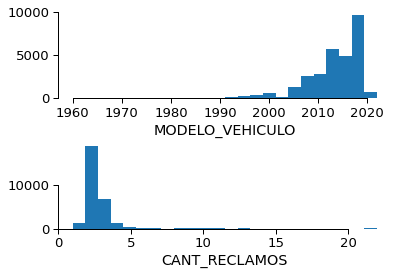

In [13]:
# Distribuciones de algunas columnas
see_columns = ["MODELO_VEHICULO", "CANT_RECLAMOS"]
sns.set_context("paper", font_scale=1.5)
_, axs = plt.subplots(nrows=len(see_columns))
for i, column in enumerate(see_columns):
    axs[i].hist(data[column], bins=24)
    axs[i].set_xlabel(column)
    axs[i].spines["right"].set_visible(False)
    axs[i].spines["top"].set_visible(False)
sns.despine(trim=True)
plt.subplots_adjust(hspace=0.5)
plt.show()

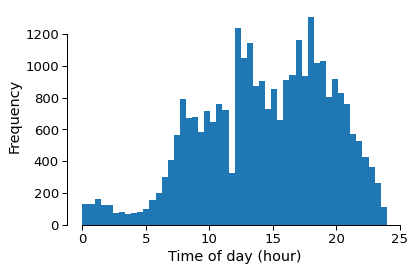

In [14]:
# Convertir HORA_SINI a un float con el momento del día
data["HORA_SINI"] = (
    pd.to_datetime(data["HORA_SINI"], format="%H:%M") - np.datetime64("1900-01-01 00:00:00")
) / np.timedelta64(1, "h") % 24
sns.set_context("paper", font_scale=1.5)
plt.hist(data["HORA_SINI"], bins="auto")
plt.ylabel("Frequency")
plt.xlabel("Time of day (hour)")
sns.despine(trim=True)
plt.show()

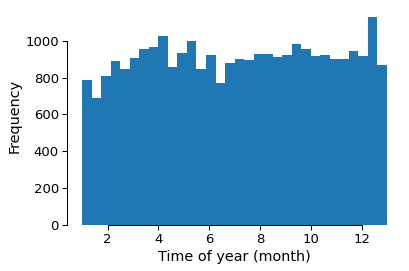

In [15]:
# Calcular momento en el año a partir de FECHA_SINI
data["FECHA_SINI_MES"] = (
    pd.to_datetime(data["FECHA_SINI"]) - np.datetime64("1900-01-01 00:00:00")
) / np.timedelta64(1, "M") % 12 + 1
sns.set_context("paper", font_scale=1.5)
plt.hist(data["FECHA_SINI_MES"], bins="auto")
plt.ylabel("Frequency")
plt.xlabel("Time of year (month)")
sns.despine(trim=True)
plt.show()

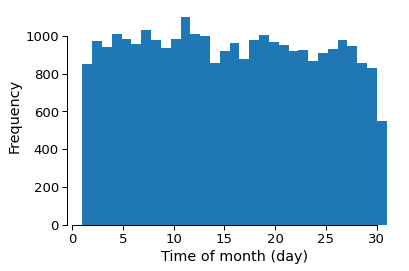

In [16]:
# Calcular día del mes a partir de FECHA_SINI
data["FECHA_SINI_DIA_MES"] = pd.to_datetime(data["FECHA_SINI"]).dt.day
sns.set_context("paper", font_scale=1.5)
plt.hist(data["FECHA_SINI_DIA_MES"], bins=31)
plt.ylabel("Frequency")
plt.xlabel("Time of month (day)")
sns.despine(trim=True)
plt.show()

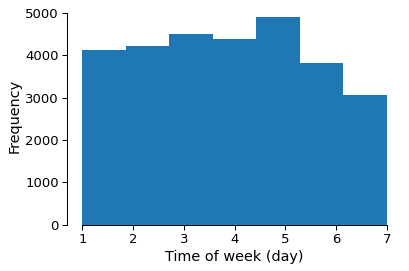

In [17]:
# Calcular día de la semana a partir de FECHA_SINI (Monday=1)
data["FECHA_SINI_DIA_SEMANA"] = pd.to_datetime(data["FECHA_SINI"]).dt.dayofweek + 1
sns.set_context("paper", font_scale=1.5)
plt.hist(data["FECHA_SINI_DIA_SEMANA"], bins=7)
plt.ylabel("Frequency")
plt.xlabel("Time of week (day)")
sns.despine(trim=True)
plt.show()

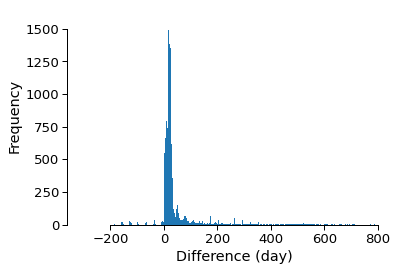

In [18]:
# Calcular la diferencia en días entre FECHA_PROCESO y FECHA_SINI
data["FECHA_PROCESO_DIF"] = (
    pd.to_datetime(data["FECHA_PROCESO"]) - pd.to_datetime(data["FECHA_SINI"])
) / np.timedelta64(1, "D")
sns.set_context("paper", font_scale=1.5)
plt.hist(data["FECHA_PROCESO_DIF"], bins="auto")
plt.ylabel("Frequency")
plt.xlabel("Difference (day)")
sns.despine(trim=True)
plt.show()

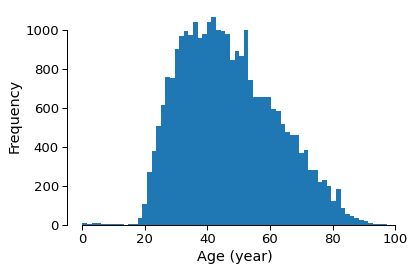

In [19]:
# Calcular edad del asegurado, tratando edad > 100 como missing
data["EDAD_ASEG"] = (
    np.datetime64("2022-01-01") - pd.to_datetime(data["FECHA_NAC_ASEG"])
) / np.timedelta64(1, 'Y')
data.loc[data["EDAD_ASEG"] > 100, "EDAD_ASEG"] = np.nan
sns.set_context("paper", font_scale=1.5)
plt.hist(data["EDAD_ASEG"], bins="auto")
plt.ylabel("Frequency")
plt.xlabel("Age (year)")
sns.despine(trim=True)
plt.show()

In [20]:
# Convertir el código postal a un distrito de mayor extensión, por ejemplo,
# utilizando una tabla para mapear código postal -> provincia
zip_codes_data = pd.read_csv(
    "codigos-postales.csv", sep=",", header=0
).astype("str").set_index("CP")
data["PROV_OCURRENCIA"] = data["COD_POST_OCURRENCIA"].astype("str").str[:4].map(
    zip_codes_data["Provincia"].to_dict()
)
del zip_codes_data
data["PROV_OCURRENCIA"].value_counts()

Buenos Aires           13520
Capital Federal         5552
Cordoba                 2050
Santa Fe                1255
Chaco                    911
Tucuman                  717
Salta                    580
Misiones                 544
Formosa                  416
Mendoza                  359
Entre Rios               278
La Pampa                 254
San Juan                 230
Catamarca                207
La Rioja                 178
Rio Negro                169
Jujuy                    163
Corrientes               150
Santiago Del Estero      150
San Luis                 149
Chubut                   130
Neuquen                  123
Santa Cruz                83
Tierra Del Fuego          17
Name: PROV_OCURRENCIA, dtype: int64

In [21]:
# Simplificar LUGAR_OCURRENCIA
places_dict = {
    "Avenida": ["avenida", "avda", "av ", "av."],
    "Acceso": ["acceso", "acc ", "acc.", "ac ", "ac.", "colec"],
    "Autopista": ["autopista", "autop ", "autop.", "au ", "au."],
    "Ruta": ["ruta", "ru ", "rut ", "ru.", "rut."]
}
lowercase_places = data["LUGAR_OCURRENCIA"].str.lower().copy()
data["LUGAR_OCURRENCIA"] = pd.Series("Otro", index=lowercase_places.index)
for place, search in places_dict.items():
    match = lowercase_places.str.contains("|".join(search)).fillna(False)
    data.loc[match, "LUGAR_OCURRENCIA"] = place
del lowercase_places, places_dict
data["LUGAR_OCURRENCIA"].value_counts()

Otro         15677
Avenida       8574
Ruta          1945
Acceso        1688
Autopista     1120
Name: LUGAR_OCURRENCIA, dtype: int64

In [22]:
# Convertir OCUPACION_ASEG a etiquetas
data["OCUPACION_ASEG"] = data["OCUPACION_ASEG"].fillna(0).astype(int).astype(str)
data["OCUPACION_ASEG"].value_counts().head(10)

5        11667
999       4115
99999     3057
44        2339
9999      1518
13         956
8          939
28         632
1          530
25         351
Name: OCUPACION_ASEG, dtype: int64

In [23]:
# Características de columnas categóricas
data.drop(columns="DESCRIP_HECHO").describe(include="object")

,TIPO_RECLAMO,FECHA_SINI,LUGAR_OCURRENCIA,ESTADO_CIVIL,FECHA_NAC_ASEG,SEXO,OCUPACION_ASEG,FECHA_PROCESO,TIPO_ADMINISTRACION,LATITUD,LONGITUD,TIPO_ADMINISTRACION_FIN,PROV_OCURRENCIA
count,29004,29004,29004,28486,28800,29004,29004,29004,29004,5569,5569,29004,28185
unique,2,746,5,10,16492,2,48,40,5,5200,5159,5,24
top,NO TRANSPORTADO,12/18/2019,Otro,CA,1/1/1900,M,5,12/31/2019,A,-58.37388176,-34.60810232,A,Buenos Aires
freq,27452,109,15677,13580,838,21113,11667,2086,11569,32,32,13760,13520


In [24]:
# Eliminar algunos atributos
data = data.drop(columns=[
    "id_reclamo_evento", "id_reclamo", "TIPO_RECLAMO",
    "TIPO_ADMINISTRACION_FIN", "FECHA_PROCESO", "FECHA_SINI", "FECHA_NAC_ASEG", "COD_POST_OCURRENCIA", # Fueron transformadas a otras columnas
    "LATITUD", "LONGITUD", # Tienen demasiados missing values
    "OCUPACION_ASEG" # Demasiada variabilidad, muchas categorías con pocas observaciones
])

In [25]:
# Veamos algunas columnas categóricas
show_categorical_columns = data.columns[data.dtypes=="object"]
show_categorical_columns = show_categorical_columns[data[show_categorical_columns].nunique() < 20]
data_cuentas = pd.crosstab(**data[show_categorical_columns].melt(var_name="index", value_name="columns"))
data_cuentas = data_cuentas.reindex(show_categorical_columns)
for i in data_cuentas.index:
    """Sort row i by column values"""
    data_cuentas = data_cuentas[data_cuentas.columns[data_cuentas.loc[i].argsort()]]
fig = px.bar(
    data_cuentas,
    x = data_cuentas.index,
    y = data_cuentas.columns,
    color_discrete_sequence=px.colors.qualitative.T10
)
fig.update_layout(
    xaxis_tickangle=-45,
    xaxis_title="Categorical Columns",
    yaxis_title="Count",
    legend_title_text="Possible values",
    font_color="black",
    plot_bgcolor="white",
)
fig.show()

---
### Procesamiento de texto

Convertir las descripciones de los siniestros en conjuntos de ngrams, para luego clasificarlos usando un modelo Naive Bayes.

El modelo Naive Bayes es uno de los modelos más sencillos de NLP, y tiene capacidad de aprender features interesantes.

Se podrían explorar modelos más complejos con redes neuronales recurrentes o con transformers, por ejemplo.

In [27]:
# Named Entity Recognition, Tokenizer, SpellChecker, Stemmer y tamaño de los ngrams
ner = StanzaPipeline(lang="es", processors="tokenize, ner", verbose=False, use_gpu=False) # Lo estoy corriendo en una laptop sin GPU
tokenizer = RegexpTokenizer(r"[a-zA-Z]+")
spell = SpellChecker(distance=3, language="es")
stemmer = SnowballStemmer("spanish")
n_ngram = 5

In [28]:
# Funciones para transformar las descripciones de los siniestros
def text_preprocessing(words, ner, tokenizer, spell, stemmer):
    """Pre-procesamiento de texto."""
    # Remover Named Entities (nombres propios de lugares, personas, organizaciones y miscelánea)
    i = 0
    new_words = ""
    for entity in ner(words).ents:
        new_words += words[i:entity.start_char]
        i = entity.end_char
    new_words += words[i:]

    # Cambiar a minúsculas
    new_words = new_words.lower()

    # Remover números, puntuación y separar en palabras
    new_words = tokenizer.tokenize(new_words)

    # Corrección ortográfica
    new_words = [word if word in spell else spell.correction(word) for word in new_words]

    # Remover stop words
    new_words = [word for word in new_words if word not in set(stopwords.words("spanish"))]

    # Obtener stems
    new_words = [stemmer.stem(word) for word in new_words]

    return new_words

# Calcular ngrams
def ngram_features(words, n):
    """Retorna ngrams observados en words, desde orden 1 hasta n."""
    return {ngram: True for ngram in everygrams(words, 1, n)}

In [29]:
# Pipeline de procesamiento de texto
nlp_preprocessor = lambda x: ngram_features(text_preprocessing(x, ner, tokenizer, spell, stemmer), n_ngram)

# Procesar descripciones de los siniestros (se tarda 7 horas en mi compu, así que guardé los resultados en un pickle)
# La parte del pipeline que más tiempo toma es la de NER: se podría omitir ese paso, procesar en paralelo con multiprocessing, o usar una GPU
# data["DESCRIP_HECHO"] = data["DESCRIP_HECHO"].map(nlp_preprocessor)
# data["DESCRIP_HECHO"].to_pickle("nlp_text.pickle")
data["DESCRIP_HECHO"] = pd.read_pickle("nlp_text.pickle")


---
### Conjuntos de entrenamiento y de prueba

In [30]:
# Dividir los datos en conjuntos de train y test
[
    idx_train, idx_test,
    X_train, X_test,
    y_train, y_test
] = train_test_split(
    data.index,
    data.drop(columns=["target"]),
    data["target"],
    test_size=0.2,
    random_state=42
)

In [31]:
# Un vistazo a los atributos
X_train.head()

,LUGAR_OCURRENCIA,ESTADO_CIVIL,SEXO,MODELO_VEHICULO,DESCRIP_HECHO,HORA_SINI,CANT_RECLAMOS,FECHA_SINI_MES,FECHA_SINI_DIA_MES,FECHA_SINI_DIA_SEMANA,FECHA_PROCESO_DIF,EDAD_ASEG,PROV_OCURRENCIA
id_evento,,,,,,,,,,,,,
23811,Otro,CA,F,2016.0,"{('asegur',): True, ('asegur', 'sal'): True, (...",12.00,2,10.828292,27,7,4.0,42.612785,Capital Federal
5654,Avenida,SO,M,2018.0,"{('asegur',): True, ('asegur', 'circul'): True...",0.25,2,3.698782,24,7,7.0,44.261005,Buenos Aires
13145,Avenida,SO,F,2015.0,"{('circul',): True, ('circul', 'rotond'): True...",17.00,2,11.732294,23,2,7.0,47.075573,Buenos Aires
10514,Otro,SO,M,2017.0,"{('deten',): True, ('deten', 'semafor'): True,...",17.00,2,5.571511,20,1,11.0,26.500202,Cordoba
23039,Avenida,CA,F,2012.0,"{('deten',): True, ('deten', 'semafor'): True,...",20.50,2,10.499743,17,4,14.0,56.378981,Capital Federal


---
### Implementación de modelos de clasificación

In [32]:
# Incorporar el NaiveBayesClassifier de nltk a pipelines de sklearn
# NaiveBayesScores devuelve el log-odds de la descripción de un siniestro
# A mayor log-odds, mayor es la probabilidad estimada de que el asegurado tenga la responsabilidad del siniestro
class NaiveBayesScores(BaseEstimator, TransformerMixin):
    """Wrapper para hacer compatible con la API de sklearn al NaiveBayesClassifier de nltk."""
    def __init__(self, labels_dict):
        self.labels_dict = labels_dict

    def fit(self, X, y=None):
        tuples = self.naive_bayes_tuples(X.values, y.values)
        self._nb = NaiveBayesClassifier.train(tuples)
        return self

    def transform(self, X, y=None):
        X = X.values
        X_new = []
        for i in range(len(X)):
            logprob = self._nb.prob_classify(X[i][0])._prob_dict
            X_new.append(
                logprob[self.labels_dict["positive"]] - logprob[self.labels_dict["negative"]]
            )
        return np.array(X_new).reshape(-1, 1)

    def naive_bayes_tuples(self, X, y):
        return [(X[i][0], y[i]) for i in range(len(X))]


In [33]:
# Grupos de columnas según los tipos de atributos
text_columns = ["DESCRIP_HECHO"]
categorical_columns = list(
    X_train.drop(columns=text_columns).columns[
        X_train.drop(columns=text_columns).dtypes == object
    ]
)
numeric_columns = list(X_train.columns[X_train.dtypes != object])

In [34]:
# Pipelines de preprocesamiento para los modelos
# Se prueban dos modelos, lr: LogisticRegression y gb: GradientBoostingClassifier
lr_preprocessor = ColumnTransformer([
    (
        "text",
        make_pipeline(NaiveBayesScores(labels_dict={"positive": 1, "negative": 0}), RobustScaler()),
        text_columns
    ),
    (
        "categorical",
        make_pipeline(SimpleImputer(strategy="most_frequent"), OneHotEncoder()),
        categorical_columns
    ),
    (
        "numeric",
        make_pipeline(SimpleImputer(strategy="median"), RobustScaler()),
        numeric_columns
    )
])
gb_preprocessor = ColumnTransformer([
    (
        "text",
        make_pipeline(NaiveBayesScores(labels_dict={"positive": 1, "negative": 0})),
        text_columns
    ),
    (
        "categorical",
        make_pipeline(SimpleImputer(strategy="most_frequent"), OrdinalEncoder()),
        categorical_columns
    ),
    (
        "numeric",
        make_pipeline(SimpleImputer(strategy="median"), "passthrough"),
        numeric_columns
    )
])

In [35]:
# Modelo Regresión Logística
model_lr = make_pipeline(lr_preprocessor, LogisticRegression(max_iter=1000))
model_lr.fit(X_train, y_train)
y_pred_lr = model_lr.predict(X_test)
y_prob_lr = model_lr.predict_proba(X_test)[:, 1]

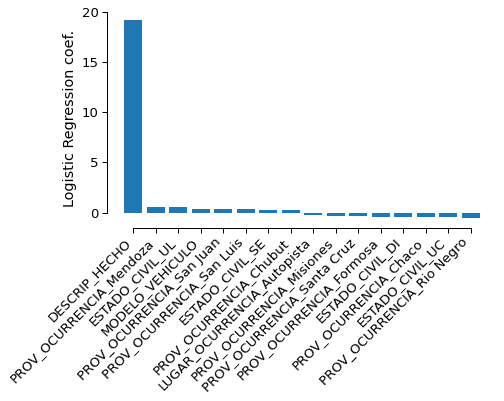

In [36]:
# Coeficientes Regresión Logística
n_most_relevant = 8
plt.figure(figsize=(7, 4))
one_hot_categories = OneHotEncoder().fit(X_train[categorical_columns]).get_feature_names_out(categorical_columns)
labels_lr = np.concatenate([text_columns, one_hot_categories, numeric_columns])
coefs_lr = model_lr._final_estimator.coef_[0]
sort_lr = list(np.argsort(coefs_lr)[::-1])
plt.bar(
    labels_lr[sort_lr[:n_most_relevant] + sort_lr[-n_most_relevant:]],
    coefs_lr[sort_lr[:n_most_relevant] + sort_lr[-n_most_relevant:]]
    )
plt.xticks(rotation=45, ha="right")
plt.ylabel("Logistic Regression coef.")
sns.despine(trim=True)
plt.show()
plt.close()

In [37]:
# Modelo Gradient Boosting
model_gb = make_pipeline(gb_preprocessor, GradientBoostingClassifier(n_estimators=200, min_samples_split=0.01, min_samples_leaf=0.0025))
model_gb.fit(X_train, y_train)
y_pred_gb = model_gb.predict(X_test)
y_prob_gb = model_gb.predict_proba(X_test)[:, 1]

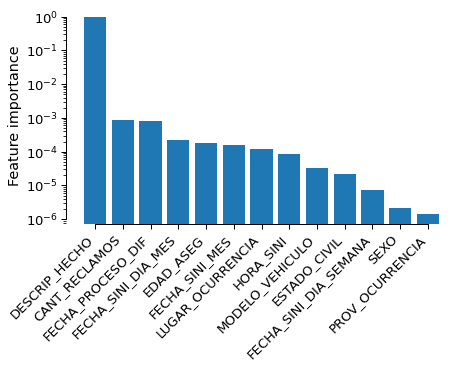

In [38]:
# Importancia de los features en Gradiant Boosting
plt.figure(figsize=(7, 4))
sns.set_context("paper", font_scale=1.5)
labels_gb = np.concatenate([text_columns, categorical_columns, numeric_columns])
importance_gb = model_gb._final_estimator.feature_importances_
sort_gb = np.argsort(importance_gb)[::-1]
plt.bar(
    labels_gb[sort_gb],
    importance_gb[sort_gb]
    )
plt.xticks(rotation=45, ha="right")
plt.ylabel("Feature importance")
plt.yscale("log")
sns.despine(trim=True)
plt.show()
plt.close()

---
### Conclusiones

Hay 3 órdenes de magnitud de diferencia entre la importancia de DESCRIP_HECHO (el atributo más importante) y de CANT_RECLAMOS (el segundo más importante), para el modelo Gradient Boost.

Para el resto de los atributos, la importancia se hace más pequeña, hasta llegar a 6 órdenes de magnitud de diferencia para SEXO y PROV_OCURRENCIA, respecto de DESCRIP_HECHO.

Algo similar se observa en los órdenes de magnitud de los coeficientes en la Regresión Logística.

Esto indica que los modelos se están guiando únicamente por DESCRIP_HECHO y son prácticamente independientes de los demás atributos.

Lo cual tiene sentido, pues se quiere determinar si el asegurado es responsable de un siniestro o no, según la ley de tránsito, y la ley de tránsito no involucra factores como la edad del asegurado, ni la fecha en que ocurre el siniestro, ni ninguna otra característica en nuestros datos que no sea la descripción del hecho.

Tal vez podría ser importante LUGAR_OCURRENCIA (calle, avenida, ruta, etc.), ya que la ley de tránsito puede depender del tipo de vía de circulación, pero esta información también puede estar incluida en DESCRIP_HECHO.

In [86]:
# Extraer el modelo NaiveBayesClassifier (nb) de uno de los pipelines
model_nb = model_lr.named_steps["columntransformer"].named_transformers_["text"].named_steps["naivebayesscores"]

In [45]:
# Calcular la probabilidad de que el asegurado sea responsable, a partir de los log-odds del model_nb
# Es decir, convirtamos log-odds en probabilidad
y_prob_nb = model_nb.transform(X_test[text_columns])[:, 0]
y_prob_nb = np.exp(y_prob_nb)
y_prob_nb = y_prob_nb / (1 + y_prob_nb)

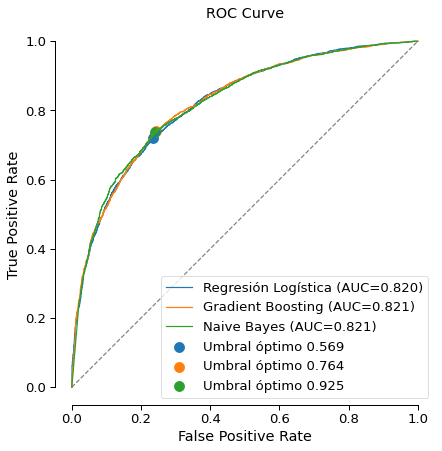

In [89]:
# Curvas ROC
plt.figure(figsize=(7, 7))
sns.set_context("paper", font_scale=1.5)
for y_prob, name in zip(
    [y_prob_lr, y_prob_gb, y_prob_nb],
    ["Regresión Logística", "Gradient Boosting", "Naive Bayes"]
):
    fpr, tpr, thres = roc_curve(y_test, y_prob)
    plt.plot(
        fpr,
        tpr,
        label=f"{name} (AUC={roc_auc_score(y_test, y_prob):.3f})"
    )
    gmeans = np.sqrt(tpr * (1 - fpr))
    opt_idx = gmeans.argmax()
    plt.scatter(
        fpr[opt_idx],
        tpr[opt_idx],
        s=100,
        label=f"Umbral óptimo {thres[opt_idx]:.3f}",
    )
plt.plot([0, 1], [0, 1], c="gray", linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.gca().set_aspect("equal", adjustable="box")
sns.despine(trim=True)
plt.show()

Los modelos probados tienen performances similares, a juzgar por las curvas ROC, apoyando la hipótesis de que el atributo más importante en este problema es el obtenido a partir de DESCRIP_HECHO.

In [59]:
# Función para graficar la matriz de confusión de un modelo
def plot_confusion_matrix(matrix, title):
    """Heatmap de la matriz de confusión de un modelo de clasificación."""
    plt.figure(figsize=(7, 7))
    sns.set_context("paper", font_scale=1.5)
    ax = sns.heatmap(
        matrix / np.sum(matrix) * 100,
        annot=True, fmt=".2f", cmap="Blues",
        vmin=0, vmax=100
    )
    ax.set_xlabel("Predicted Values")
    ax.set_ylabel("Actual Values")
    ax.xaxis.set_ticklabels(["False", "True"])
    ax.yaxis.set_ticklabels(["False", "True"])
    ax.xaxis.set_ticks_position("none")
    ax.yaxis.set_ticks_position("none")
    cbar = ax.collections[0].colorbar
    cbar.ax.tick_params(length=0)
    cbar.set_label("Probabilidad (%)")
    plt.title(title)
    plt.gca().set_aspect("equal", adjustable="box")
    plt.show()
    plt.close()

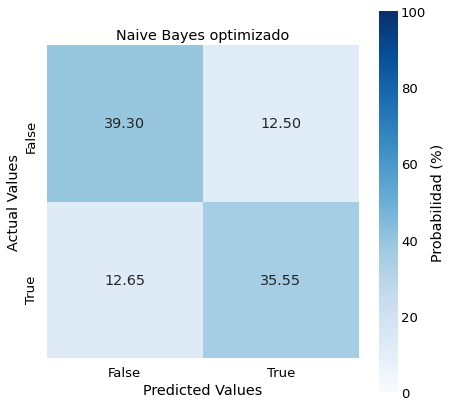

In [61]:
# Matriz de confusion del modelo NaiveBayesClassifier,
# con un umbral de decisión óptimo (según gmeans)
fpr, tpr, thres = roc_curve(y_test, y_prob_nb)
gmeans = np.sqrt(tpr * (1 - fpr))
opt_idx = gmeans.argmax()
opt_theta = thres[opt_idx]
y_pred_opt = (y_prob_nb > opt_theta).astype(int)
confusion_opt = confusion_matrix(y_test, y_pred_opt)
plot_confusion_matrix(confusion_opt, "Naive Bayes optimizado")

En nuestro caso, nos conviene elegir un umbral que reduzca la tasa de Falsos Negativos (aumente la tasa de Verdaderos Positivos).

Pues es más costoso que se escape un asegurado responsable de un siniestro y quede sin detectar, respecto de clasificar erróneamente a un asegurado como responsable.

Por lo tanto, habría que elegir un umbral que aumente el recall de los positivos.

In [64]:
# Métricas NaiveBayesClassifier
y_pred_opt = (y_prob_nb > opt_theta).astype(int)
print(classification_report(y_test, y_pred_opt))

              precision    recall  f1-score   support

           0       0.76      0.76      0.76      3005
           1       0.74      0.74      0.74      2796

    accuracy                           0.75      5801
   macro avg       0.75      0.75      0.75      5801
weighted avg       0.75      0.75      0.75      5801



El accuracy de nuestro modelo sencillo es de 75%.

Bastante por debajo del 91% de accuracy de un operador humano.

Pero mucho mejor que el accuracy debido al azar (aproximadamente 50%).

In [71]:
accuracy_human = (tipo_administracion.loc[idx_test].map(target_dict) == y_test).mean()
accuracy_chance = y_test.mean()
print(f"Human accuracy:\t {accuracy_human:.2f}")
print(f"Chance accuracy: {accuracy_chance:.2f}")

Human accuracy:	 0.91
Chance accuracy: 0.48


Veamos qué normas de tránsito aprendió el modelo NaiveBayesClassifier.

In [80]:
# Estos son los ngrams con mayor likelihood de estar en una desripción positiva (1) o negativa (0)
most_informative_list = model_nb._nb.most_informative_features(n=10)
model_nb._nb.show_most_informative_features(n=10)

Most Informative Features
('mot', 'choc', 'atras') = True                1 : 0      =     32.4 : 1.0
('asegur', 'deten', 'semafor', 'tercer') = True                1 : 0      =     29.4 : 1.0
('traser', 'mot', 'circul', 'detr') = True                1 : 0      =     29.2 : 1.0
('part', 'traser', 'mot', 'circul', 'detr') = True                1 : 0      =     28.8 : 1.0
('part', 'delanter', 'tercer', 'circul', 'detr') = True                1 : 0      =     27.2 : 1.0
('asegur', 'estacion', 'ocup') = True                1 : 0      =     24.7 : 1.0
('deten', 'semafor', 'colision', 'part', 'traser') = True                1 : 0      =     24.3 : 1.0
('traser', 'tercer', 'detien') = True                0 : 1      =     24.2 : 1.0
('semafor', 'colision', 'part', 'traser') = True                1 : 0      =     22.8 : 1.0
('asegur', 'deten', 'transit', 'colision') = True                1 : 0      =     22.0 : 1.0


In [76]:
# Veamos cuáles son las descripciones que contienen al segundo ngram más importante ('asegur', 'deten', 'semafor', 'tercer')
text_match = data["DESCRIP_HECHO"].map(lambda x: ('asegur', 'deten', 'semafor', 'tercer') in x)

In [83]:
# Esta es una de esas descripciones
descrip_hecho.loc[text_match].iloc[0]

'ASEGURADO DETENIDO POR SEMAFORO SOBRE AV. M. BUFFANO CUANDO UN TERCERO (F-100) QUE CIRCULABA SOBRE LA MISMA , LO IMPACTA CON LA PARTE DELANTERA EN LA PARTE TRASERA ASEG.. PRODUCTO DEL MISMO EL VH ASEG. SE DESPLAZA Y COLISIONA A OTRO TERCERO (CHEV.) CON PARTE DELANTERA EN LA PARTE TRASERA TERC.. AMIGO DEL ASEG. CON DOLENCIAS Y GOLPES.  SIN LESIONES TERCERO .-'

In [85]:
# Donde el asegurado es responsable
data["target"].loc[text_match].iloc[0]

1

El modelo aprendió, por ejemplo, que si el asegurado está detenido en un semáforo y un tercero lo impacta en la parte trasera, entonces es muy probable que el asegurado sea responsable del siniestro.

---
### Pasos a seguir

Viendo que el problema puede ser resulto con NLP de las descripciones de los siniestros, un próximo paso sería implementar modelos de lenguaje más complejos (RNN y transformers).

El modelo seleccionado puede luego llevarse a producción y hacer un deployment usando un Docker container, por ejemplo.

El único input que sería necesario, para este modelo, sería la descripción del siniestro.

También, se pueden implementar esquemas de CI/CD para mantener el modelo entrenado y actualizado con las descripciones de siniestros más recientes.

Por ej., si se elige el modelo Naive Bayes, se pueden actualizar las likelihoods de los ngrams y los valores de las priors del modelo.

Por último, se pueden plantear esquemas de validación y de tuning de hiperparámetros.

Por ej., para nuestro NaiveBayesClassifier, se podrían comparar las performances con diferentes valores de tamaño de ngram máximo.